# 2025-10-03 Snohomish Quadtree/HydroMT Build

List of goals:
1. Use simplified shapefiles, and plot along the way
2. Use "duo-sfincs" conda environment (both cht_sfincs and HydroMT-SFINCS)
3. Use DFM model output

Starting with imports, file paths, and parameters (e.g. start and end times...)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dataretrieval.nwis as nwis
import utm
import xarray as xr
import geopandas as gpd
from cht_sfincs import SFINCS
from cht_bathymetry import BathymetryDatabase
from pyproj import CRS
import os

geojsons = {'Snohomish County [Expanded]'   : '/home/cassandra/Snohomish/2025-10-geojsons/Snohomish_county_expanded.geojson',
            'Model Domain'                  : '/home/cassandra/Snohomish/2025-10-geojsons/Snohomish_active_inner.geojson',
            'Channel Refinements'           : '/home/cassandra/Snohomish/2025-10-geojsons/snohomish_county_south_channels.geojson',
            'Levees'                        : '/home/cassandra/Snohomish/2025-10-geojsons/Snohomish_levees_lower_delta_3.geojson',
            'Water/Sea Boundary Area'       : '/home/cassandra/Snohomish/2025-10-geojsons/Snohomish_water_bound.geojson'}

dem_path = '/home/cassandra/Data/Snoh_DEM_composite/Snohomish_MosaicDEM.tif'
man_path = '/home/cassandra/Snohomish/test_data/snohomish_manning.tif'

dfm_path = '/home/cassandra/Data/Snohomish_all.nc'

site_names = ['Monroe',     'Pilchuck',  'Snohomish',  'Duvall',    
              'Gold Bar',   'Wallace',   'Sultan',    'Quilceda', 
              'Carnation',  'Marysville','Stanwood', 'Arlington',
              'Deer Creek', 'Granite Falls', 'Arlington (2)']
site_nums  = ['12150800', '12155300',  '12155500',  '12150400',  
              '12134500', '12135000',  '12138160',  '12157005', 
              '12149000', '12157000',  '12170300',  '12167400',
              '12166500', '12161000',  '12167000']

quadtree_dir = '/home/cassandra/Snohomish/2025-10/'
parent_dir   = '/home/cassandra/Snohomish/2025-10/2013/'

t0 = np.datetime64('2013-11-01')
tf = np.datetime64('2014-11-01')

if not os.path.exists(quadtree_dir):
    os.mkdir(quadtree_dir)
if not os.path.exists(parent_dir):
    os.mkdir(parent_dir)

Recall we chose this time because of relative availability of downriver validation from NOAA for their floodplain restoration project monitoring, i.e:

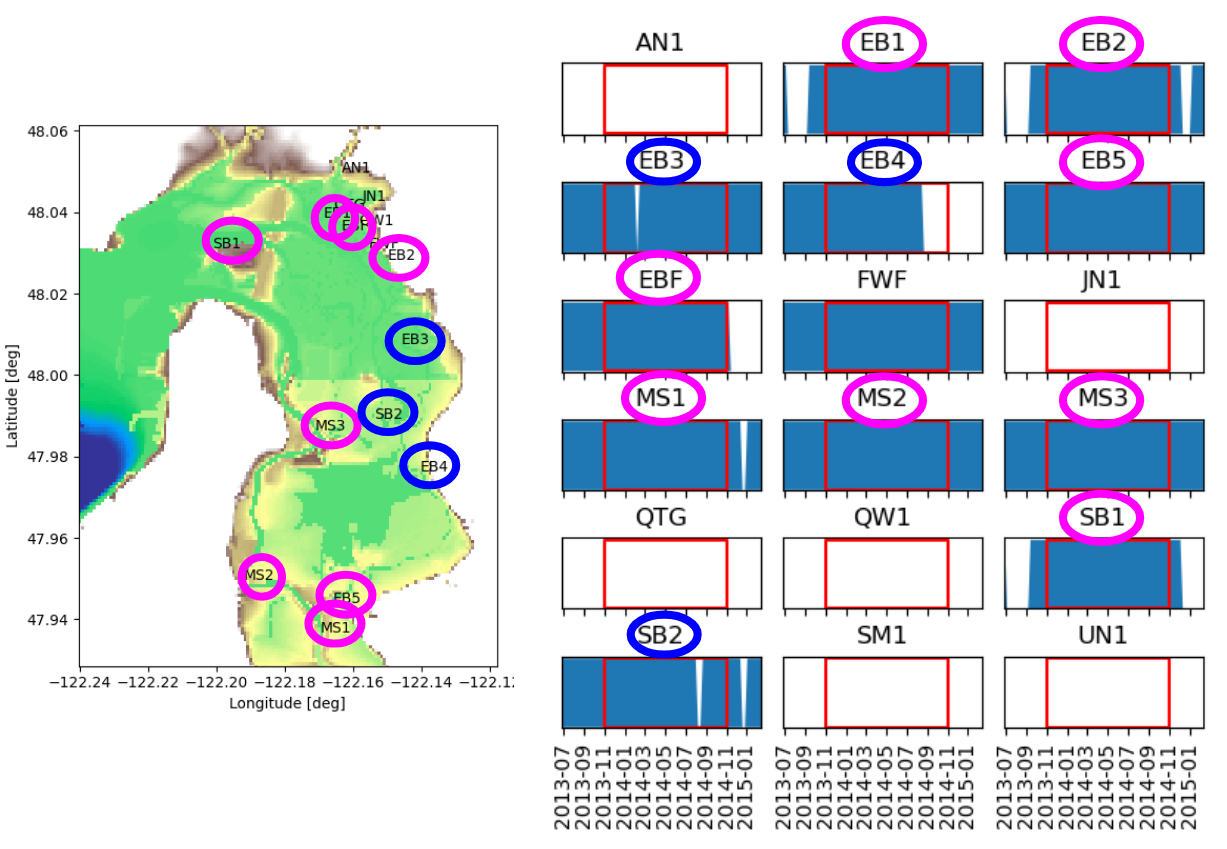

(where pink means full availability and blue means mostly available)

Let's start with visualizing the model domain with inputs and refinements. For domain, we first need discharges...

## USGS Stream Gages

In [2]:
# sdf = nwis.get_record(sites=site_nums, service='site')
# ddf = nwis.get_record(sites=site_nums, service='dv', start=str(t0), end=str(tf))

# sdf.to_csv('/home/cassandra/Snohomish/test_data/2025-10-sdf.csv')
# ddf.to_csv('/home/cassandra/Snohomish/test_data/2025-10-ddf.csv')

sdf = pd.read_csv('/home/cassandra/Snohomish/test_data/2025-10-sdf.csv')
ddf = pd.read_csv('/home/cassandra/Snohomish/test_data/2025-10-ddf.csv')

valid_sites = np.unique(ddf['site_no'].values)

Snohomish is not available
Wallace is not available
Quilceda is not available
Marysville is not available
Arlington is not available
Deer Creek is not available
Granite Falls is not available


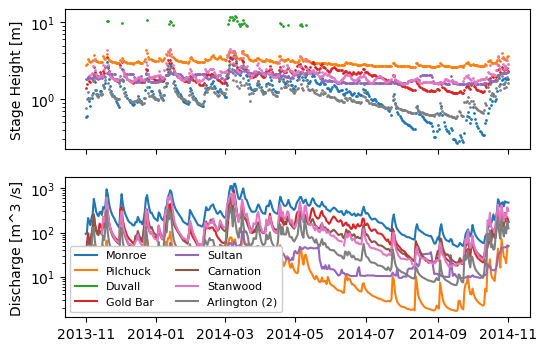

In [3]:
mpf = 0.3048
cmpcf = mpf**3

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
sites, time, discharge, stage = ddf['site_no'], ddf['datetime'], ddf['00060_Mean'], ddf['00065_Mean']
time = pd.to_datetime(time).values

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(6,4))
for s,n in zip(site_nums, site_names):
    is_site = sites == int(s)
    if np.nansum(is_site) == 0:
        print(n, 'is not available')
        continue
    c = colors.pop(0)
    axs[0].scatter(time[is_site], stage[is_site] * mpf, label=n, s=1, color=c)
    axs[1].plot(time[is_site], discharge[is_site] * cmpcf, label=n, color=c)
axs[0].set_ylabel("Stage Height [m]")
axs[1].set_ylabel("Discharge [m^3 /s]")
axs[1].legend(fontsize=8, framealpha=1, ncols=2)
axs[0].set_yscale('log')
axs[1].set_yscale('log')
plt.show()

The lack of Snohomish river gage is a bummer (it gives a relatively high upriver validation point) but what we have here isn't so bad. For location reference, see this map:

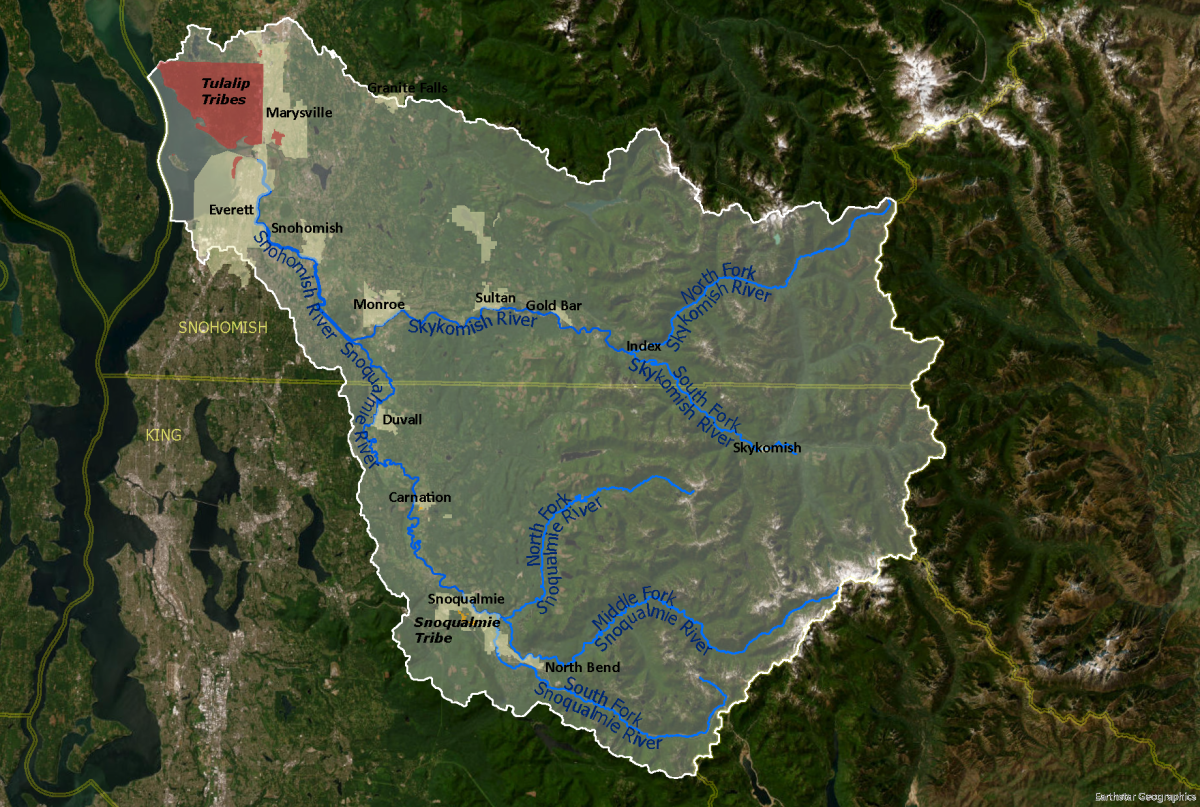

Given the available gages, here is my thinking:

1. Monroe will be used to adjust higher inputs (proportional to their sizes) so they add up to what Monroe observes
2. Pilchuck will be used as is
3. Duvall will be replaced with Carnation, which is further upriver, and will be adjusted according to Monroe
4. Gold Bar will be adjusted according to Monroe
5. Sultan will be adjusted according to Monroe
6. Carnation will be used in place of Duvall. It's upriver of Duvall, but I want the model input at Duvall.

On the Stillaguamish side, there are only two data points:
1. Stanwood (which is tidal)
2. Arlington -- which will have to be used as-is.
I'm not quite satisfied with the presumed discharge for Stillaguamish but it is what it is.

Let's adjust and see what we get.

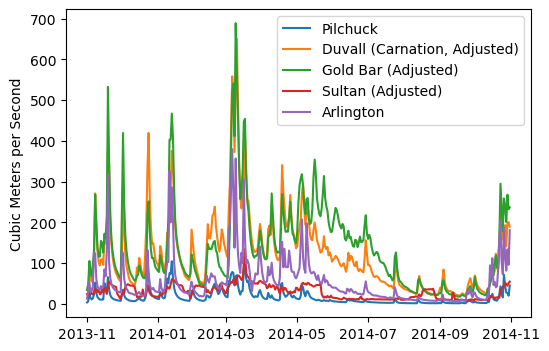

In [4]:
mpf = 0.3048
cmpcf = mpf**3

# Grid things on a shared time grid
t = np.arange(t0, tf, np.timedelta64(1, 'D'))
site_discharge = {}
site_latlon = {}
for s,n in zip(site_nums, site_names):
    lat = sdf['dec_lat_va'][np.where(sdf['site_no'] == int(s))[0][0]]
    lon = sdf['dec_long_va'][np.where(sdf['site_no'] == int(s))[0][0]]
    site_latlon.update({n: [lat,lon]})
    is_site = sites == int(s)
    if np.nansum(is_site) == 0:
        site_discharge.update({n:np.nan*np.ones(len(t))})
        continue
    site_discharge.update({n:np.interp(t.astype('datetime64[ms]').astype(float), 
                                       time[is_site].astype('datetime64[ms]').astype(float), 
                                       discharge[is_site]*cmpcf)})
# Access discharges
pilchuck  = site_discharge['Pilchuck']
duvall    = site_discharge['Carnation'] # Use Carnation because Duvall not available
goldbar   = site_discharge['Gold Bar']
sultan    = site_discharge['Sultan']
arlington = site_discharge['Arlington (2)']

# Adjust so Duvall + Goldbar + Sultan add up to Monroe at any given time
monroe_actual = site_discharge['Monroe']
monroe_sum    = duvall + goldbar + sultan
factor = monroe_actual / monroe_sum
duvall, goldbar, sultan = duvall*factor, goldbar*factor, sultan*factor

# Get locations in UTM
p_x, p_y, _, __ = utm.from_latlon(*site_latlon['Pilchuck'])
d_x, d_y, _, __ = utm.from_latlon(*site_latlon['Duvall'])
g_x, g_y, _, __ = utm.from_latlon(*site_latlon['Gold Bar'])
s_x, s_y, _, __ = utm.from_latlon(*site_latlon['Sultan'])
a_x, a_y, _, __ = utm.from_latlon(*site_latlon['Arlington (2)'])

# Make necessary arrays
station_names = ['Pilchuck', 'Duvall (Carnation, Adjusted)', 'Gold Bar (Adjusted)', 'Sultan (Adjusted)', 'Arlington']
station_discharge = np.array([pilchuck, duvall, goldbar, sultan, arlington]) 

# Create a DataArray
discharge_da = xr.DataArray(station_discharge.T,
                            coords={"time": t,
                                    "location": station_names,
                                    "x": ("location", [p_x, d_x, g_x, s_x, a_x]),
                                    "y": ("location", [p_y, d_y, g_y, s_y, a_y]), },
                            dims=["time", "location"],
                            name="discharge")

discharge_da.to_netcdf('/home/cassandra/Snohomish/test_data/2025-10-discharge.nc')

plt.figure(figsize=(6,4))
for n,d in zip(station_names, station_discharge):
    plt.plot(t, d, label=n)
plt.ylabel("Cubic Meters per Second")
plt.legend()
# plt.yscale('log')
plt.show()

## Tide
I have a DFM model output for tide but it needs to be reformatted, which is very simple:

In [5]:
dfm_tide_file = '/home/cassandra/Data/Snohomish_all.nc'
dfm_tides = xr.open_dataset(dfm_tide_file)
tide_t = dfm_tides.time.values
# Convert matlab datenum to datetime64
def matlab2datetime(matlab_datenum, round_to):
    t = pd.to_datetime(matlab_datenum - 719529, unit='D')
    # Solution isn't exact so this round cleans things up
    t_clean = t.round(freq=round_to)  # hour 'min',
    return t_clean
tide_t = matlab2datetime(tide_t, 'min')
# Compute time bound
tide_t_ok = np.logical_and(tide_t >= t0, tide_t <= tf)
tide_t = tide_t[tide_t_ok]
# Get water level and convert to meters
tide_h = dfm_tides.WL_2016_2099[:, tide_t_ok].values / 100
# Convert lat, lon to utm
tide_x, tide_y, _, __ = utm.from_latlon(dfm_tides.lat.values, dfm_tides.lon.values)
# Make HydroMT SFINCS compatible DataArray
tide_da = xr.DataArray(tide_h.T,
                       coords={"time": tide_t,
                               "location": dfm_tides.sta_name.values,
                               "x": ("location", tide_x),
                               "y": ("location", tide_y), },
                       dims=["time", "location"],
                       name="tide")

tide_da.to_netcdf('/home/cassandra/Snohomish/test_data/2025-10-tide.nc')

### Plot of DEM, Refinement, & Input Points

It's time to put it all together and make sure it looks reasonable...

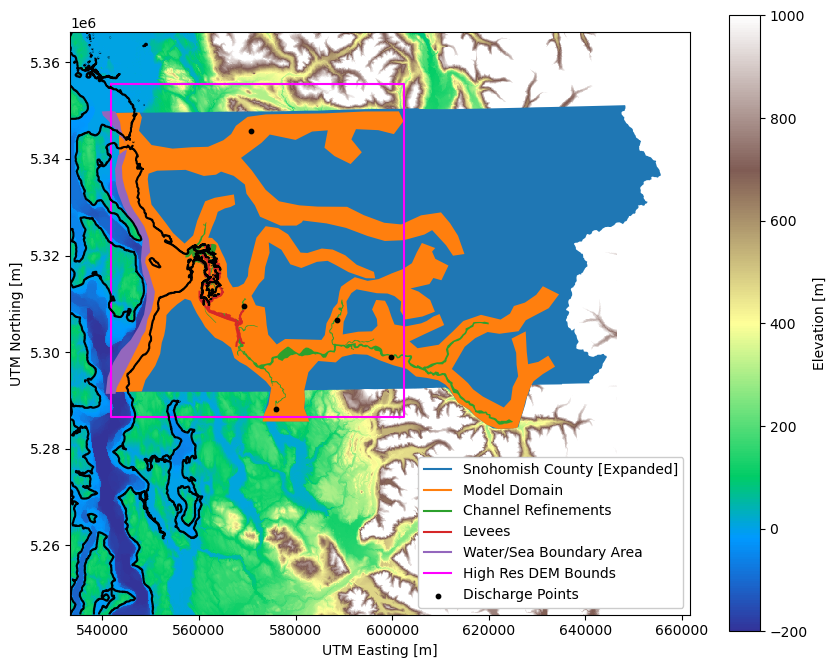

In [6]:
# Load low res DEM for this
dem = xr.open_dataset('/home/cassandra/Snohomish/test_data/snohomish_DEM.tif')
lat, lon = dem.y.values, dem.x.values
x, _, _, __ = utm.from_latlon(np.nanmean(lat)*np.ones(len(lon)), lon)
_, y, _, __ = utm.from_latlon(lat, np.nanmean(lon)*np.ones(len(lat)))

# Warning, high res
dem_hi = xr.open_dataset(dem_path)
dhx, dhy = dem_hi.x.values, dem_hi.y.values

# Plot
fig, ax = plt.subplots(figsize=(10,8))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
m = plt.pcolormesh(x, y, dem.band_data[0], cmap='terrain', shading='nearest', vmax=1000, vmin=-200)
for i, name in enumerate(list(geojsons)):
    gdf = gpd.read_file(geojsons[name])
    gdf = gdf.set_crs('EPSG:4326').to_crs('EPSG:32610')
    gdf.plot(ax=ax, alpha=1.0, color=colors[i], figsize=fig.get_size_inches())
    ax.plot([np.nan, np.nan], color=colors[i], label=name)
plt.plot([dhx[0], dhx[0], dhx[-1], dhx[-1], dhx[0]], [dhy[0], dhy[-1], dhy[-1], dhy[0], dhy[0]], color='magenta', label='High Res DEM Bounds')
plt.scatter([p_x, d_x, g_x, s_x, a_x], [p_y, d_y, g_y, s_y, a_y], color='black', label='Discharge Points', s=10)
plt.contour(x, y, dem.band_data[0], [0], colors='black')
plt.legend(framealpha=1, fontsize=10, loc=4)
cb = plt.colorbar(m)
cb.ax.set_ylabel("Elevation [m]")
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
fig.savefig(quadtree_dir + 'overview.png', dpi=800)
plt.show()

## Quadtree Build

Next step is to build the quadtree...

In [7]:
# Use bounds of high res bathy for initial grid
x_min, x_max = dhx[0], dhx[-1]
y_min, y_max = dhy[-1], dhy[0]

# Quadtree grid characteristics
dx, dy = 160, 160
nmax = int((y_max - y_min)/dy) + 1
mmax = int((x_max - x_min)/dx) + 1
rotation = 0
crs = CRS("WGS 84 / UTM zone 10N")

# Load relevant polygons
include_polygon         = gpd.read_file(geojsons['Model Domain'           ]).set_crs('EPSG:4326').to_crs('EPSG:32610')
water_boundary_polygons = gpd.read_file(geojsons['Water/Sea Boundary Area']).set_crs('EPSG:4326').to_crs('EPSG:32610')
refinement_polygons     = gpd.read_file(geojsons['Channel Refinements'    ]).set_crs('EPSG:4326').to_crs('EPSG:32610')

# Add a refinement level -- just 2 for everything
levels = 3 * np.ones(len(refinement_polygons)).astype(int)
refinement_polygons = refinement_polygons.assign(refinement_level = levels)

# Create bathymetry database & set
bdb = BathymetryDatabase()
bdb.add_dataset_from_file("dem", dem_path)
bdb.add_dataset_from_file("man", man_path)
bathymetry_sets = [{"name": "dem"}]
roughness_sets  = [{"name": "man"}]

Path to bathymetry database not set !


In [ ]:
# %%capture cap 
# # "Magic Command" to squash cell output, becuase this stuff tends to print a lot of diagnostics
# # Has to be at very top

# SFINCS quadtree build (no subgrid table)
sf = SFINCS(mode="wt", crs=crs)
sf.grid.build(x_min, y_min, nmax, mmax,  dx, dy, rotation,
              refinement_polygons=refinement_polygons,
              bathymetry_sets=bathymetry_sets,
              bathymetry_database=bdb)
sf.grid.set_bathymetry(bathymetry_sets, bathymetry_database=bdb)
sf.mask.build(include_polygon=include_polygon,
              open_boundary_polygon=water_boundary_polygons,
              outflow_boundary_polygon=land_boundary_polygons)
sf.grid.cut_inactive_cells()
if os.path.exists(quadtree_dir + "sfincs.nc"): os.remove(quadtree_dir + "sfincs.nc")
sf.grid.write(quadtree_dir + "sfincs.nc")
if os.path.exists(subg_file): os.remove(subg_file)
sf.subgrid.build(bathymetry_sets, roughness_sets, file_name=subg_file,
                 roughness_type="manning", 
                 manning_land=0.04, manning_water=0.020, manning_level=1.0,
                 nr_levels=10, nr_subgrid_pixels=20, huthresh=0.01, 
                 zmin=-20.0, zmax=999999.0, bathymetry_database=bdb)

# # Save output of this cell to a file
# with open('quadtree_build_log.txt', 'w') as file:
#     file.write(cap.stdout)

Building mesh ...
Refining ...
Time elapsed : 45.48042416572571 s
Finding neighbors ...
Time elapsed : 0.0765237808227539 s
Setting neighbors left and below ...
Time elapsed : 0.21150732040405273 s
Getting uv points ...
Time elapsed : 0.39395928382873535 s
Making XUGrid ...
Got rid of duplicates in 1.5406 seconds
Made XUGrid in 0.0060 seconds


At this point, it crashes. It seems as though it is allocating way more memory than is available, as the way it crashes is consistent with other memory crashes I've run into, but its worth noting the memory demands are not very high, up to the moment of crash. 